In [36]:
import os
import json
from collections import defaultdict

import pandas as pd
from tqdm import tqdm
from transformers import  pipeline, Conversation

In [ ]:
from datasets import load_dataset

dataset = load_dataset(r"ceval/ceval-exam", name="computer_network")

print(dataset["val"][0])
# {'id': 0, 'question': '使用位填充方法，以01111110为位首flag，数据为011011111111111111110010，求问传送时要添加几个0____', 'A': '1', 'B': '2', 'C': '3', 'D': '4', 'answer': 'C', 'explanation': ''}

In [ ]:
print(dataset["test"][0])

每个科目由三个部分组成：dev、val 和 test。每个科目的 dev 集包含五个示范实例以及为 few-shot 评估提供的解释。val 集旨在用于超参数调整。而 test 集则用于模型评估。test 集上的标签不会公开，需要用户提交其结果才能自动获得测试准确性

In [ ]:
print(dataset.keys())
for key, val in dataset.items():
    print(key, len(val))

In [ ]:
# 重新保存成中文可读的
import json
with open("./data/subject_mapping.json", "r", encoding="utf-8") as f:
    subject_mapping = json.load(f)
with open("./data/subject_mapping.json", "w", encoding="utf-8") as f:
    json.dump(subject_mapping, f, ensure_ascii=False, indent=2)

In [13]:
# 看下总共有多少数据
count = 0
data_list = []
for name, item in subject_mapping.items():
    en_name = item[0]
    zh_name = item[1]
    category = item[2]

    dataset = load_dataset(r"ceval/ceval-exam", name=name)

    count += len(dataset["test"])

    data_list.append({
        "name": name,
        "en_name": en_name,
        "zh_name": zh_name,
        "category": category,
        "test_num": len(dataset["test"]),
        "val_num": len(dataset["val"]),
        "dev_num": len(dataset["dev"]),
    })

print(count)

Found cached dataset ceval-exam (C:/Users/zhenh/.cache/huggingface/datasets/ceval___ceval-exam/computer_network/1.0.0/89fbc67f62695f2fe47dc983507c72b12dab83fbfbd4162f4d5dc4746d669cbf)
100%|██████████| 3/3 [00:00<00:00, 999.83it/s]
Found cached dataset ceval-exam (C:/Users/zhenh/.cache/huggingface/datasets/ceval___ceval-exam/operating_system/1.0.0/89fbc67f62695f2fe47dc983507c72b12dab83fbfbd4162f4d5dc4746d669cbf)
100%|██████████| 3/3 [00:00<00:00, 1107.07it/s]
Found cached dataset ceval-exam (C:/Users/zhenh/.cache/huggingface/datasets/ceval___ceval-exam/computer_architecture/1.0.0/89fbc67f62695f2fe47dc983507c72b12dab83fbfbd4162f4d5dc4746d669cbf)
100%|██████████| 3/3 [00:00<00:00, 1000.07it/s]
Found cached dataset ceval-exam (C:/Users/zhenh/.cache/huggingface/datasets/ceval___ceval-exam/college_programming/1.0.0/89fbc67f62695f2fe47dc983507c72b12dab83fbfbd4162f4d5dc4746d669cbf)
100%|██████████| 3/3 [00:00<00:00, 999.68it/s]
Found cached dataset ceval-exam (C:/Users/zhenh/.cache/huggingface

12342


In [15]:
df = pd.DataFrame(data_list)
print(df.shape)
df.head(3)

(52, 7)


,name,en_name,zh_name,category,test_num,val_num,dev_num
0,computer_network,Computer Network,计算机网络,STEM,171,19,5
1,operating_system,Operating System,操作系统,STEM,179,19,5
2,computer_architecture,Computer Architecture,计算机组成,STEM,193,21,5


<AxesSubplot:xlabel='zh_name'>

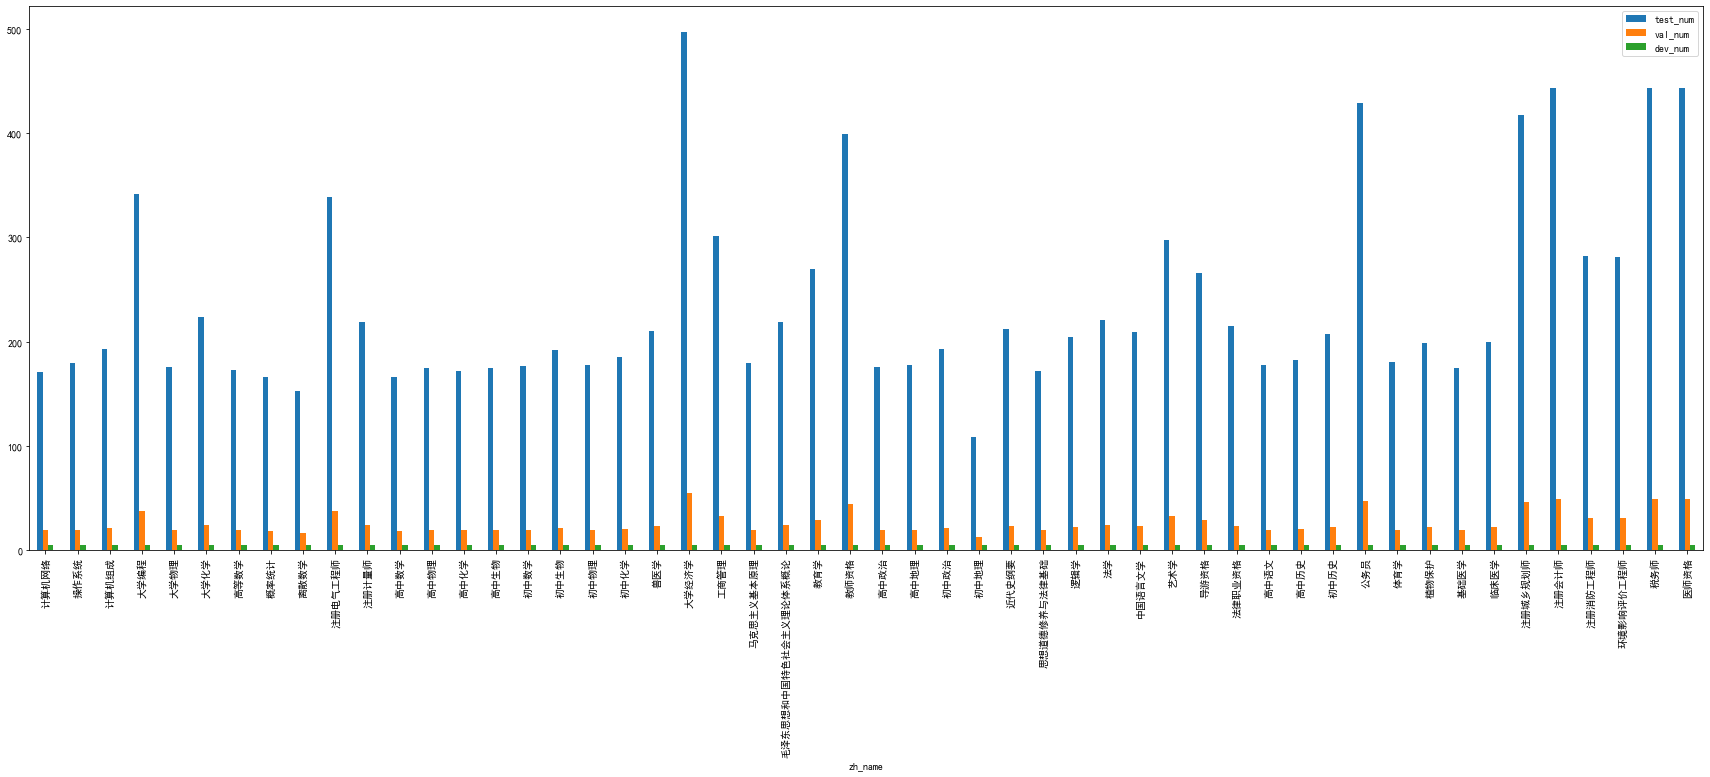

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 设置字体参数
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

df.plot(kind="bar", x="zh_name", y=["test_num", "val_num", "dev_num"], figsize=(30, 10))

In [22]:
from baichaun_chat import load_baichuan_model, pipeline_chat

In [23]:
model, tokenizer = load_baichuan_model()

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


bin c:\tech\Anaconda3\envs\nlp\lib\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


Loading checkpoint shards: 100%|██████████| 3/3 [01:00<00:00, 20.30s/it]

cuda:0 torch.float16


In [28]:
dataset["dev"][0], zh_name

({'id': 0,
  'question': '医学伦理学的核心问题是____',
  'A': '医务人员之间的关系',
  'B': '医务人员与患者的关系',
  'C': '医务人员与社会之间的关系',
  'D': '医务人员与科学发展之间的关系',
  'answer': 'B',
  'explanation': '1. 医务人员与患者的关系，是医学伦理学的核心问题和主要研究对象。'},
 '医师资格')

In [50]:
# 只为单次对话构建, 不包含多轮对话
chat_template = """
<reserved_106>{{messages[0]["content"]}}<reserved_107>
""".strip().replace(
    "\n", ""
)

def build_content(example, zh_name):
    content = """
    以下是中国关于{科目}考试的单项选择题，请选出其中的正确答案。
    {测试题目}
    A. {选项A}
    B. {选项B}
    C. {选项C}
    D. {选项D}
    答案：
    """.format(
        科目=zh_name,
        测试题目=example["question"],
        选项A=example["A"],
        选项B=example["B"],
        选项C=example["C"],
        选项D=example["D"],
    )
    # 去掉每一行的首尾空格
    content = "\n".join([line.strip() for line in content.split("\n")])
    return content

chat = [
    {"role": "user", "content": build_content(dataset["dev"][0], zh_name)}
]
model.chat_template = chat_template
print(tokenizer.apply_chat_template(chat, tokenize=False))

<reserved_106>以下是中国关于医师资格考试的单项选择题，请选出其中的正确答案。
医学伦理学的核心问题是____
A. 医务人员之间的关系
B. 医务人员与患者的关系
C. 医务人员与社会之间的关系
D. 医务人员与科学发展之间的关系
答案：<reserved_107>


In [46]:
# 这个长度不设置有点坑, 默认怎么会是 20, 都不知道是哪里设置的
model.config.max_length = 4096
tokenizer.pad_token_id = tokenizer.eos_token_id

# 初始化 pipeline
chatbot = pipeline("conversational", model=model, tokenizer=tokenizer)

content = build_content(dataset["test"][0], zh_name)

# 开启一个对话
conversation = Conversation(content)
conversation = chatbot(conversation)
print(conversation.generated_responses[-1])

Both `max_new_tokens` (=2048) and `max_length`(=4096) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


A


# 零样本测试

In [51]:
# 定义模型的 prompt

# 只为单次对话构建, 不包含多轮对话
chat_template = """
<reserved_106>{{messages[0]["content"]}}<reserved_107>
""".strip().replace(
    "\n", ""
)

def build_content(example, zh_name):
    content = """
    以下是中国关于{科目}考试的单项选择题，请选出其中的正确答案。
    {测试题目}
    A. {选项A}
    B. {选项B}
    C. {选项C}
    D. {选项D}
    答案：
    """.format(
        科目=zh_name,
        测试题目=example["question"],
        选项A=example["A"],
        选项B=example["B"],
        选项C=example["C"],
        选项D=example["D"],
    )
    # 去掉每一行的首尾空格
    content = "\n".join([line.strip() for line in content.split("\n")])
    return content

chat = [
    {"role": "user", "content": build_content(dataset["dev"][0], zh_name)}
]
model.chat_template = chat_template
print(tokenizer.apply_chat_template(chat, tokenize=False))

# 这个长度不设置有点坑, 默认怎么会是 20, 都不知道是哪里设置的
model.config.max_length = 4096
tokenizer.pad_token_id = tokenizer.eos_token_id

# 初始化 pipeline
chatbot = pipeline("conversational", model=model, tokenizer=tokenizer)

<reserved_106>以下是中国关于医师资格考试的单项选择题，请选出其中的正确答案。
医学伦理学的核心问题是____
A. 医务人员之间的关系
B. 医务人员与患者的关系
C. 医务人员与社会之间的关系
D. 医务人员与科学发展之间的关系
答案：<reserved_107>


In [ ]:
# 保存最终的结果
result = defaultdict(dict)
# 保存详细的推理结果
detail_list = []


# 遍历每一个学科的题目
for name, item in subject_mapping.items():
    en_name = item[0]
    zh_name = item[1]
    category = item[2]

    dataset = load_dataset(r"ceval/ceval-exam", name=name)

    for example in tqdm(dataset["test"], desc=zh_name):
        id = example["id"]
        content = build_content(example, zh_name)

        # 开启一个对话
        conversation = Conversation(content)
        conversation = chatbot(conversation)
        response = conversation.generated_responses[-1]

        # 只取第一个值
        result[name][id] = response[0]

        # 保存详细的推理结果
        detail_list.append({
            "name": name,
            "en_name": en_name,
            "zh_name": zh_name,
            "category": category,
            "predict": response[0],
            "response": response,
            **example,  # 加上原始的数据
        })

# TODO: 太慢了, 1366 条, 跑了 50 分钟. 这里 test 总共有 12342 条.

In [56]:
len(detail_list)

1366

In [55]:
with open("detail.json", "w", encoding="utf-8") as f:
    json.dump(detail_list, f, ensure_ascii=False, indent=2)